In [1]:
import sys
import time
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir = "dataset/"
expression_labels = os.listdir(data_dir)
num_classes = len(expression_labels)

In [3]:
def preprocess_image(image):
    # Convert image to grayscale
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian Blur
    image_blurred = cv2.GaussianBlur(image_gray, (5, 5), 0)
    
    # Apply Histogram Equalization
    image_equalized = cv2.equalizeHist(image_blurred)
    
    # Apply Intensity Thresholding
    _, image_thresholded = cv2.threshold(image_equalized, 127, 255, cv2.THRESH_BINARY)
    
    # Resize image to 128x128 (input shape expected by the model)
    image_resized = cv2.resize(image_thresholded, (128, 128))
    
    return image_resized


In [4]:
# Initialize lists to hold images and labels
X, y = [], []

# Load images and labels
for label_id, label in enumerate(expression_labels):
    images = os.listdir(os.path.join(data_dir, label))
    for img in images:
        img_path = os.path.join(data_dir, label, img)
        image = cv2.imread(img_path)
        image = preprocess_image(image)
        X.append(image)
        y.append(label_id)

In [5]:
# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# Define early stopping callback
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)

In [8]:
# Initialize CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [9]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [10]:
# Reshape input data (add a channel dimension for grayscale images)
X_train = X_train.reshape(X_train.shape[0], 128, 128, 1)
X_test = X_test.reshape(X_test.shape[0], 128, 128, 1)


In [11]:
# Fit the model (1st round of tuning)
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=test_datagen.flow(X_test, y_test, batch_size=32),
    epochs=10
)

Epoch 1/10


387/387 [==============================] - 60s 154ms/step - loss: 1.5998 - accuracy: 0.2791 - val_loss: 1.4572 - val_accuracy: 0.3500
Epoch 2/10
387/387 [==============================] - 65s 167ms/step - loss: 1.5122 - accuracy: 0.3284 - val_loss: 1.4048 - val_accuracy: 0.3850
Epoch 3/10
387/387 [==============================] - 69s 178ms/step - loss: 1.4687 - accuracy: 0.3545 - val_loss: 1.3297 - val_accuracy: 0.4484
Epoch 4/10
387/387 [==============================] - 66s 171ms/step - loss: 1.4353 - accuracy: 0.3802 - val_loss: 1.2523 - val_accuracy: 0.4723
Epoch 5/10
387/387 [==============================] - 65s 167ms/step - loss: 1.4077 - accuracy: 0.3938 - val_loss: 1.2272 - val_accuracy: 0.4843
Epoch 6/10
387/387 [==============================] - 64s 166ms/step - loss: 1.3900 - accuracy: 0.4092 - val_loss: 1.1753 - val_accuracy: 0.5105
Epoch 7/10
387/387 [==============================] - 65s 168ms/step - loss: 1.3632 - accuracy: 0.4286 - val_loss: 1.1196 - val_

In [14]:
model.save('CNN_Round1.h5')

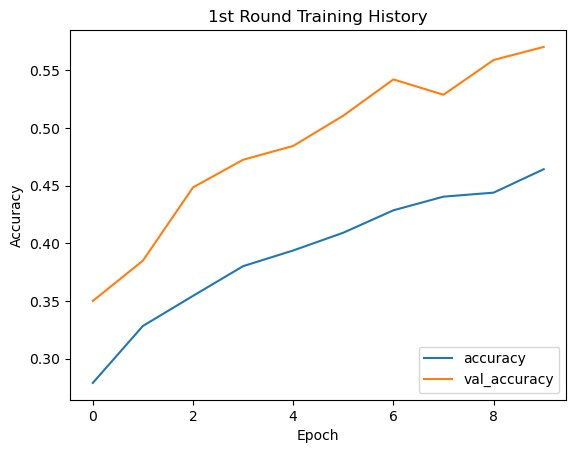

In [12]:
import matplotlib.pyplot as plt
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('1st Round Training History')
plt.show()

In [13]:
# Evaluate the model on test data after 1st round of tuning
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy for 1st round:', test_acc)


97/97 [==============================] - 3s 34ms/step - loss: 142.3754 - accuracy: 0.5018
Test accuracy for 1st round: 0.5017793774604797


In [ ]:
# Perform 2nd round of tuning (e.g., adjust learning rate, dropout rate, etc.)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fit the model (2nd round of tuning)
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    
    validation_data=test_datagen.flow(X_test, y_test, batch_size=32),
    epochs=10
)

In [ ]:
model.save('CNN_Round2.h5')

In [ ]:
# Plot training history for 2nd round
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('2nd Round Training History')
plt.show()


In [ ]:
# Evaluate the model on test data after 2nd round of tuning
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy (2nd round):', test_acc)

In [14]:
# Make predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=-1)

97/97 [==============================] - 4s 35ms/step


AUC Score: 0.7220230030618341


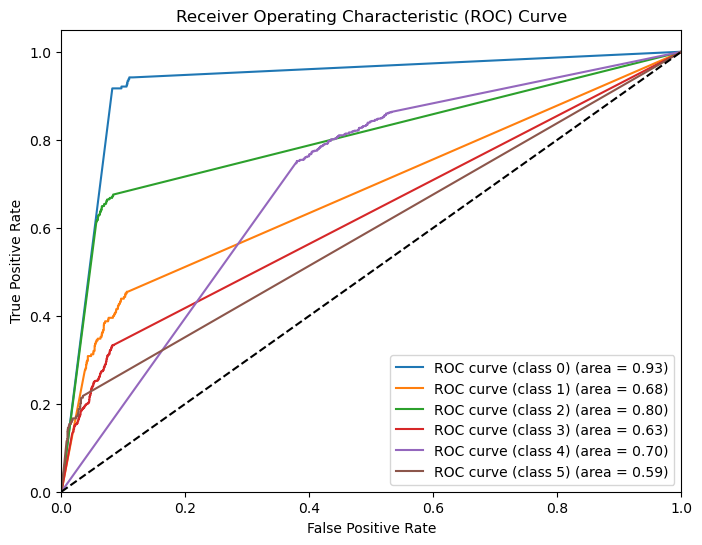

In [15]:
# Compute AUC
from sklearn.metrics import roc_auc_score, roc_curve, auc
auc_score = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
print('AUC Score:', auc_score)

# Compute ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == i), y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class {}) (area = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

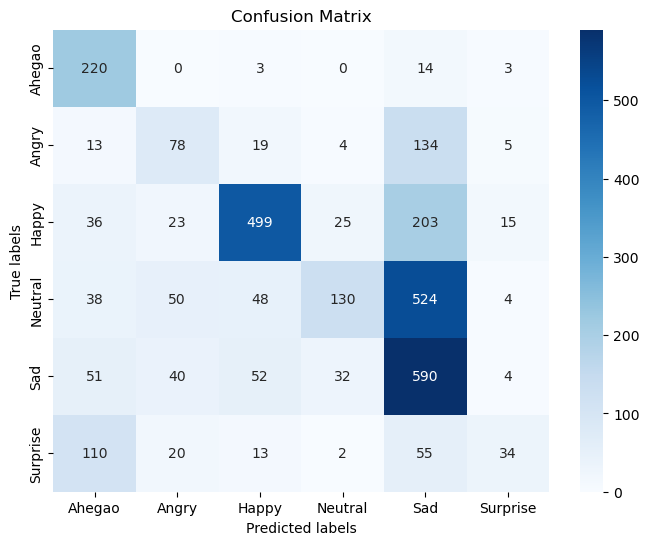

In [16]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=expression_labels, yticklabels=expression_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [17]:
import cv2

In [18]:
# Define a function to preprocess the input face image
def preprocess_face(image):
    try:
        # Ensure that the input is a valid numpy array
        if isinstance(image, np.ndarray):
            # Convert the image to grayscale
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            # Resize the image to the input shape expected by the model (e.g., 128x128)
            resized_image = cv2.resize(gray_image, (128, 128))
            
            # Normalize the pixel values to be in the range [0, 1]
            normalized_image = resized_image / 255.0
            
            # Expand dimensions to match the input shape expected by the model (add a batch dimension)
            preprocessed_image = normalized_image.reshape(1, 128, 128, 1)
            
            return preprocessed_image
        else:
            print("Error: Input is not a valid numpy array.")
            return None
    except Exception as e:
        print("Error:", e)
        return None


In [19]:
# Define a function to identify the expression given a face image
def identify_expression(face_images):
    try:
        # Preprocess the face images
        preprocessed_faces = [preprocess_face(face_image) for face_image in face_images if preprocess_face(face_image) is not None]

        if len(preprocessed_faces) == 0:
            print("Error: No valid face images for prediction.")
            return None

        # Make predictions using the trained model
        predicted_probabilities = model.predict(np.concatenate(preprocessed_faces))

        # Interpret the prediction results
        expression_labels = ["Ahegao", "Angry", "Happy", "Sad", "Surprise", "Neutral"]
        predicted_expressions = [expression_labels[np.argmax(probabilities)] for probabilities in predicted_probabilities]

        return predicted_expressions
    except Exception as e:
        print("Error:", e)
        return None


In [20]:
# Load the face image
face_image_1 = cv2.imread(r'C:\Users\Owner\Downloads\FaceExpressions\dataset\Surprise\cropped_emotions.99986~12fffff.png')
face_image_2 = cv2.imread(r'C:\Users\Owner\Downloads\FaceExpressions\dataset\Sad\cropped_emotions.6282.png')
face_image_3 = cv2.imread(r'C:\Users\Owner\Downloads\FaceExpressions\dataset\Neutral\cropped_emotions.452787f.png')
face_image_4 = cv2.imread(r'C:\Users\Owner\Downloads\FaceExpressions\dataset\Happy\cropped_emotions.570021.png')
face_image_5 = cv2.imread(r'C:\Users\Owner\Downloads\FaceExpressions\dataset\Angry\fbfc10d6b385960402080a291e57668836276e43a18aa7fd5e23c56f~angry.jpg')
face_image_6 = cv2.imread(r'C:\Users\Owner\Downloads\FaceExpressions\dataset\Ahegao\lol8~ahegao.png')


In [21]:
# Identify the expressions for multiple faces
predicted_expressions = identify_expression([face_image_1, face_image_2, face_image_3, face_image_4, face_image_5, face_image_6])

1/1 [==============================] - 0s 75ms/step


In [22]:
# Print the predicted expressions
for i, expression in enumerate(predicted_expressions):
    print("Predicted Expression", i+1, ":", expression)

Predicted Expression 1 : Sad
Predicted Expression 2 : Sad
Predicted Expression 3 : Sad
Predicted Expression 4 : Happy
Predicted Expression 5 : Happy
Predicted Expression 6 : Happy


In [23]:
model.save('CNNmodel.keras')